# Data Preprocessing

## Emotion Face Classifier Notebook 1

Reads csv data into pandas.

Converts string arrays into 2-D matrix, saves images to jpgs by usage and emotion.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datascifuncs.tidbit_tools import load_json, write_json, print_json, check_directory_name

In [4]:
main_dir = 'EmotionFaceClassifier'
check_directory_name(main_dir)

Directory set to /Users/dsl/Documents/GitHub/EmotionFaceClassifier, matches target dir string EmotionFaceClassifier.


True

In [5]:
from utils.preprocessing import (
    convert_pixels_to_array,
    save_image
)

In [6]:
# Load common dicts from json config file
common_dicts = load_json('./configs/input_mappings.json')
print_json(common_dicts)

{
    "usage_dict": {
        "Training": "Training",
        "PublicTest": "Testing",
        "PrivateTest": "Testing"
    },
    "emo_dict": {
        "0": "Angry",
        "1": "Disgust",
        "2": "Fear",
        "3": "Happy",
        "4": "Sad",
        "5": "Surprise",
        "6": "Neutral"
    },
    "category_order": [
        "Overall",
        "Angry",
        "Disgust",
        "Fear",
        "Happy",
        "Sad",
        "Surprise",
        "Neutral"
    ],
    "plotly_styles": {
        "Training": {
            "color": {
                "Angry": "red",
                "Disgust": "olive",
                "Fear": "slategray",
                "Happy": "gold",
                "Sad": "blue",
                "Surprise": "darkviolet",
                "Neutral": "sienna"
            },
            "opacity": 1.0,
            "line": {
                "color": "black",
                "width": 0.3
            },
            "pattern": {
                "shape": ""
        

In [7]:
# Select emotion mapping section of json
emo_dict = common_dicts['emo_dict']
print_json(emo_dict)

{
    "0": "Angry",
    "1": "Disgust",
    "2": "Fear",
    "3": "Happy",
    "4": "Sad",
    "5": "Surprise",
    "6": "Neutral"
}


In [8]:
# Select color mappings for emotion categories
emo_color_dict = common_dicts['plotly_styles']['Training']['color']
print_json(emo_color_dict)

{
    "Angry": "red",
    "Disgust": "olive",
    "Fear": "slategray",
    "Happy": "gold",
    "Sad": "blue",
    "Surprise": "darkviolet",
    "Neutral": "sienna"
}


In [9]:
# Get set order to display results
category_order = common_dicts['category_order']
print_json(category_order)

[
    "Overall",
    "Angry",
    "Disgust",
    "Fear",
    "Happy",
    "Sad",
    "Surprise",
    "Neutral"
]


In [10]:
# Read in FER 2013 data
fer2013_path = 'data/fer2013.csv'
fer2013 = pd.read_csv(fer2013_path)

In [11]:
# Check column names and shape
print(fer2013.columns)
print(fer2013.shape)

Index(['emotion', 'pixels', 'Usage'], dtype='object')
(35887, 3)


In [12]:
# Check emotion values
print(sorted(fer2013['emotion'].unique()))

[0, 1, 2, 3, 4, 5, 6]


In [13]:
# Map emotion labels to values for clarity
fer2013 = fer2013.rename(columns={'emotion': 'emotion_id'})
fer2013['emotion'] = fer2013['emotion_id'].astype(str).map(emo_dict)

In [14]:
# Pixel data converted to np.array
fer2013['image'] = fer2013['pixels'].apply(convert_pixels_to_array)

In [15]:
# Initial data has 3 usages: train, public test, private test
# Mapping reduces to train and test only 
fer2013['usage']=fer2013['Usage'].map(common_dicts['usage_dict'])

In [16]:
# Create groupby counts of each emotion
gby = fer2013.groupby(['emotion'], as_index=False).size()
print(gby)

    emotion  size
0     Angry  4953
1   Disgust   547
2      Fear  5121
3     Happy  8989
4   Neutral  6198
5       Sad  6077
6  Surprise  4002


In [17]:
gby

,emotion,size
0,Angry,4953
1,Disgust,547
2,Fear,5121
3,Happy,8989
4,Neutral,6198
5,Sad,6077
6,Surprise,4002


In [18]:
# Add a color column to the DataFrame based on the emotion
gby['color'] = gby['emotion'].map(emo_color_dict)

In [19]:
# Filter the order list to include only categories present in the DataFrame
filtered_order = [cat for cat in category_order if cat in gby['emotion'].unique()]

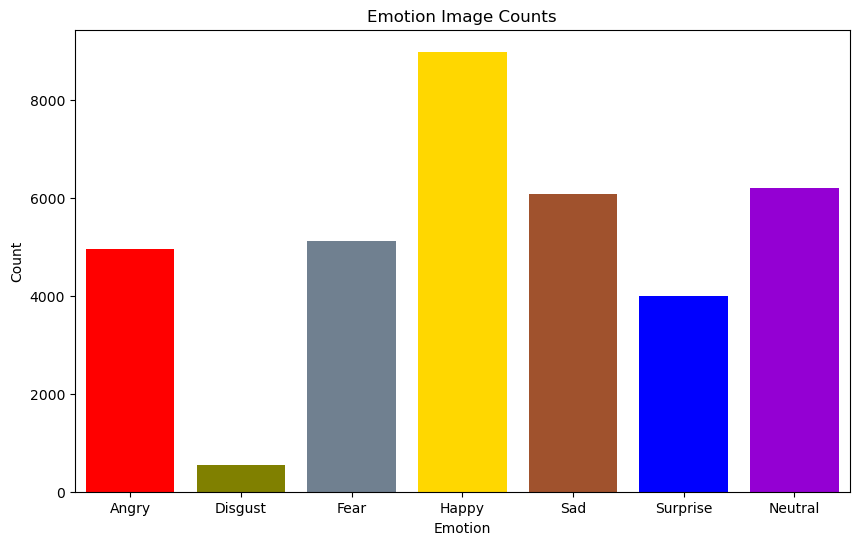

In [20]:
# Plot using Seaborn, and set colors manually after creating the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=gby, x='emotion', y='size', ax=ax, order=filtered_order)

# Apply colors
for bar, color in zip(ax.patches, gby['color']):
    bar.set_facecolor(color)

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Image Counts')
plt.show()

In [21]:
# Creates a numeric index for each usage/emotion group
# Value is used as identifier for image
fer2013['emo_count_id'] = fer2013.groupby(['usage', 'emotion']).cumcount()+1

In [22]:
# Write img arrays to jpg
# Add img path to df
fer2013['img_path'] = fer2013.apply(save_image, axis=1)

In [23]:
# Add emotion color tags
fer2013['color'] = fer2013['emotion'].map(emo_color_dict)

In [24]:
# Save updated df
save_path = os.path.join('data', 'fer2013_paths.csv')
fer2013.to_csv(save_path, index=False)